In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from patsy import dmatrices
import scipy
from scipy.stats import jarque_bera
from itertools import combinations

In [2]:
df = pd.read_csv('Data/Life Expectancy Data.csv')
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:
df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [4]:
for i, column in enumerate(df.columns):
    cols = column.strip(' ')
    cols = cols.replace(' ', '_')
    cols = cols.replace('-', '_')
    cols = cols.replace('/', '_')
    df = df.rename(columns = {column: cols})

<Axes: >

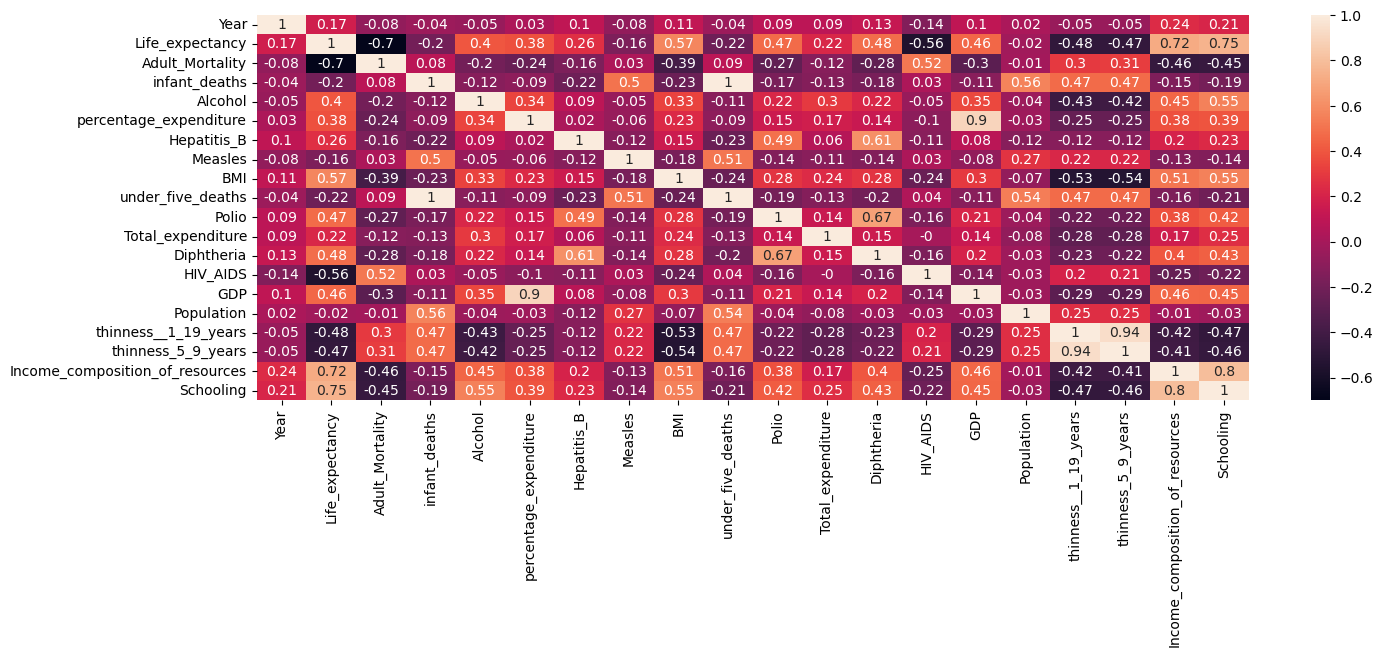

In [5]:
numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr().round(2)
plt.figure(figsize = (16,5))
sns.heatmap(data=correlation_matrix, annot=True)

In [6]:
df_new = df.drop(['under_five_deaths', 'percentage_expenditure', 'Income_composition_of_resources',
                  'thinness_5_9_years', 'thinness__1_19_years'], axis=1)
df_new['Year_Cohort'] = pd.cut(df_new['Year'], bins=[2000, 2003, 2007, 2011, 2015],
                               labels=['2000-2003', '2004-2007', '2008-2011', '2012-2015'])
df_new.dropna(subset=['Life_expectancy'], inplace=True)

In [7]:
df_new.head()

,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,Hepatitis_B,Measles,BMI,Polio,Total_expenditure,Diphtheria,HIV_AIDS,GDP,Population,Schooling,Year_Cohort
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,65.0,1154,19.1,6.0,8.16,65.0,0.1,584.259210,33736494.0,10.1,2012-2015
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,62.0,492,18.6,58.0,8.18,62.0,0.1,612.696514,327582.0,10.0,2012-2015
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,64.0,430,18.1,62.0,8.13,64.0,0.1,631.744976,31731688.0,9.9,2012-2015
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,67.0,2787,17.6,67.0,8.52,67.0,0.1,669.959000,3696958.0,9.8,2012-2015
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,68.0,3013,17.2,68.0,7.87,68.0,0.1,63.537231,2978599.0,9.5,2008-2011


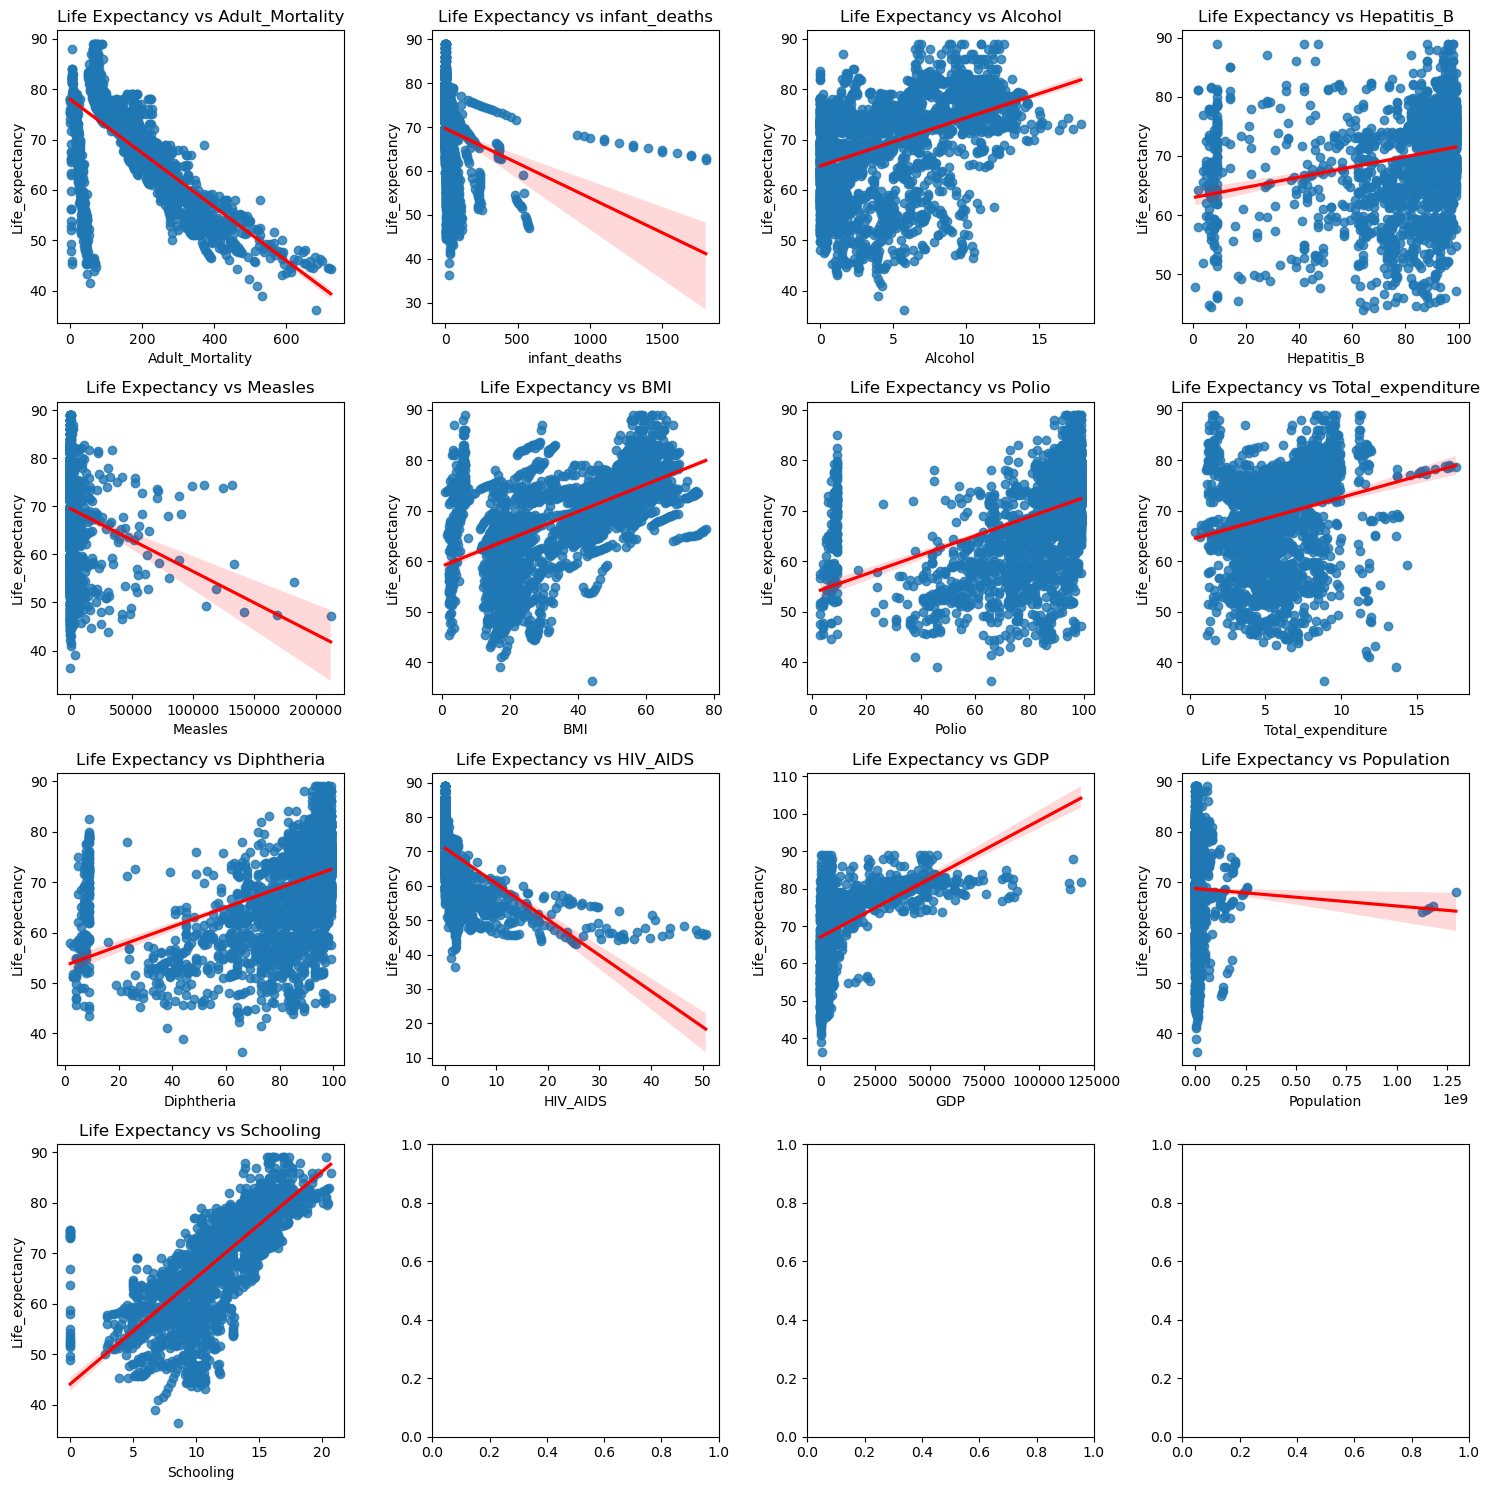

In [8]:
y = df_new['Life_expectancy']
x_vars = ['Adult_Mortality', 'infant_deaths', 'Alcohol', 'Hepatitis_B',
          'Measles', 'BMI', 'Polio', 'Total_expenditure', 'Diphtheria',
          'HIV_AIDS', 'GDP', 'Population', 'Schooling']

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
for i, x_var in enumerate(x_vars):
    row, col = divmod(i, 4)
    ax = axes[row, col]

    sns.regplot(x=x_var, y=y, data=df_new, ax=ax, line_kws={'color': 'red'})
    ax.set_title(f'Life Expectancy vs {x_var}')

plt.tight_layout()
plt.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


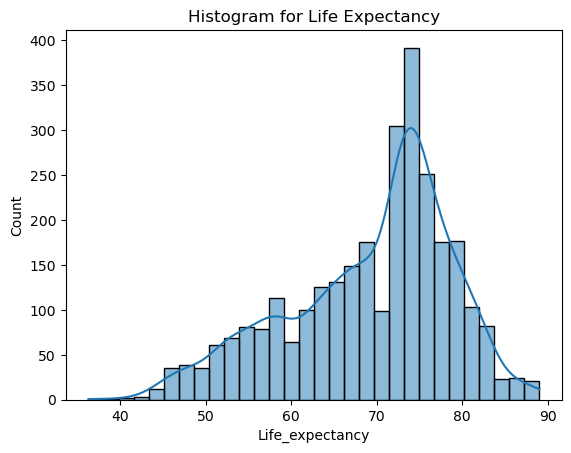

In [9]:
sns.histplot(df_new['Life_expectancy'], bins=30, kde=True)
plt.title('Histogram for Life Expectancy')
plt.show()

In [10]:
grouped = df_new.groupby(['Country', 'Year_Cohort']).agg(
    {'Life_expectancy': 'mean', 'Adult_Mortality': 'mean', 'infant_deaths': 'mean', 'Alcohol': 'mean', 'Hepatitis_B': 'mean',
     'Measles': 'mean', 'BMI': 'mean', 'Polio': 'mean', 'Total_expenditure': 'mean', 'Diphtheria': 'mean', 'HIV_AIDS': 'mean',
     'GDP': 'mean', 'Population': 'mean', 'Schooling': 'mean', 'Status':'first'}).reset_index()
grouped.columns = grouped.columns.str.replace(' ', '_')
grouped.head()

,Country,Year_Cohort,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,Hepatitis_B,Measles,BMI,Polio,Total_expenditure,Diphtheria,HIV_AIDS,GDP,Population,Schooling,Status
0,Afghanistan,2000-2003,56.066667,204.666667,87.666667,0.0100,64.000000,4015.333333,13.000000,37.333333,8.126667,36.666667,0.1,168.023825,9.103746e+06,6.200000,Developing
1,Afghanistan,2004-2007,57.275000,293.500000,84.500000,0.0225,65.000000,1223.250000,14.475000,46.000000,7.912500,46.000000,0.1,221.708762,1.339573e+07,7.800000,Developing
2,Afghanistan,2008-2011,58.675000,280.500000,75.500000,0.0150,65.250000,2365.500000,16.450000,65.250000,8.705000,65.250000,0.1,359.030146,2.218882e+06,9.075000,Developing
3,Afghanistan,2012-2015,61.075000,268.500000,65.250000,0.0100,64.500000,1215.750000,18.350000,48.250000,8.247500,64.500000,0.1,624.664925,1.737318e+07,9.950000,Developing
4,Albania,2000-2003,73.233333,15.666667,1.000000,4.0900,96.333333,14.000000,46.933333,97.333333,6.190000,97.333333,0.1,990.099241,1.264333e+05,10.666667,Developing


In [11]:
y, X = dmatrices("Life_expectancy ~ Country + C(Year_Cohort) + Adult_Mortality + infant_deaths + Alcohol + Hepatitis_B + Measles + BMI + Polio + Total_expenditure + Diphtheria + HIV_AIDS + GDP + Population + Schooling", data=grouped, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

/Users/shenyaxuan/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


     VIF Factor                        features
0    542.488545                       Intercept
1      3.492842              Country[T.Albania]
2      2.869509              Country[T.Algeria]
3      2.123457               Country[T.Angola]
4           NaN  Country[T.Antigua and Barbuda]
..          ...                             ...
194    5.410221                      Diphtheria
195    5.665008                        HIV_AIDS
196    6.736745                             GDP
197    3.870486                      Population
198   35.004129                       Schooling

[199 rows x 2 columns]


In [12]:
vif[vif["VIF Factor"] >= 10]

,VIF Factor,features
0,542.488545,Intercept
74,32.232616,Country[T.India]
187,63.850300,infant_deaths
188,12.830597,Alcohol
198,35.004129,Schooling


In [13]:
region = pd.read_csv('Data/all.csv')
region_new = region[['name','region','sub-region']]

In [14]:
grouped_new = grouped.merge(region_new, left_on='Country', right_on='name')
grouped_new.rename(columns={"sub-region": "sub_region"}, inplace=True)
grouped_new = grouped_new.drop(columns="name")
grouped_new.head()

,Country,Year_Cohort,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,Hepatitis_B,Measles,BMI,Polio,Total_expenditure,Diphtheria,HIV_AIDS,GDP,Population,Schooling,Status,region,sub_region
0,Afghanistan,2000-2003,56.066667,204.666667,87.666667,0.0100,64.000000,4015.333333,13.000000,37.333333,8.126667,36.666667,0.1,168.023825,9.103746e+06,6.200000,Developing,Asia,Southern Asia
1,Afghanistan,2004-2007,57.275000,293.500000,84.500000,0.0225,65.000000,1223.250000,14.475000,46.000000,7.912500,46.000000,0.1,221.708762,1.339573e+07,7.800000,Developing,Asia,Southern Asia
2,Afghanistan,2008-2011,58.675000,280.500000,75.500000,0.0150,65.250000,2365.500000,16.450000,65.250000,8.705000,65.250000,0.1,359.030146,2.218882e+06,9.075000,Developing,Asia,Southern Asia
3,Afghanistan,2012-2015,61.075000,268.500000,65.250000,0.0100,64.500000,1215.750000,18.350000,48.250000,8.247500,64.500000,0.1,624.664925,1.737318e+07,9.950000,Developing,Asia,Southern Asia
4,Albania,2000-2003,73.233333,15.666667,1.000000,4.0900,96.333333,14.000000,46.933333,97.333333,6.190000,97.333333,0.1,990.099241,1.264333e+05,10.666667,Developing,Europe,Southern Europe


In [15]:
mean_hepb_by_sub = grouped_new.groupby('sub_region')['Hepatitis_B'].transform('mean')
grouped_new['Hepatitis_B'].fillna(mean_hepb_by_sub, inplace=True)

mean_bmi_by_sub = grouped_new.groupby('sub_region')['BMI'].transform('mean')
grouped_new['BMI'].fillna(mean_bmi_by_sub, inplace=True)

mean_polio_by_sub = grouped_new.groupby('sub_region')['Polio'].transform('mean')
grouped_new['Polio'].fillna(mean_polio_by_sub, inplace=True)

mean_exp_by_sub = grouped_new.groupby('sub_region')['Total_expenditure'].transform('mean')
grouped_new['Total_expenditure'].fillna(mean_exp_by_sub, inplace=True)

mean_dip_by_sub = grouped_new.groupby('sub_region')['Diphtheria'].transform('mean')
grouped_new['Diphtheria'].fillna(mean_dip_by_sub, inplace=True)

mean_gdp_by_sub = grouped_new.groupby('sub_region')['GDP'].transform('mean')
grouped_new['GDP'].fillna(mean_gdp_by_sub, inplace=True)

mean_pop_by_sub = grouped_new.groupby('sub_region')['Population'].transform('mean')
grouped_new['Population'].fillna(mean_pop_by_sub, inplace=True)

mean_alc_by_sub = grouped_new.groupby('sub_region')['Alcohol'].transform('mean')
grouped_new['Alcohol'].fillna(mean_alc_by_sub, inplace=True)

mean_sch_by_sub = grouped_new.groupby('sub_region')['Schooling'].transform('mean')
grouped_new['Schooling'].fillna(mean_sch_by_sub, inplace=True)

In [16]:
grouped_new.isnull().any()

Country              False
Year_Cohort          False
Life_expectancy      False
Adult_Mortality      False
infant_deaths        False
Alcohol              False
Hepatitis_B          False
Measles              False
BMI                  False
Polio                False
Total_expenditure    False
Diphtheria           False
HIV_AIDS             False
GDP                  False
Population           False
Schooling            False
Status               False
region               False
sub_region           False
dtype: bool

In [17]:
baseline = smf.ols('Life_expectancy ~ C(region) + C(Status) + C(Year_Cohort) + Adult_Mortality + infant_deaths + Alcohol + Hepatitis_B + Measles + BMI + Polio + Total_expenditure + Diphtheria + HIV_AIDS + GDP + Population + Schooling', data=grouped_new).fit()
baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     252.8
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          5.93e-305
Time:                        21:05:30   Log-Likelihood:                -1806.5
No. Observations:                 704   AIC:                             3657.
Df Residuals:                     682   BIC:                             3757.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      56.0236      1.142     49.066      0.000      53.782      58.265
C(region)[T.Americas]           4.5775      0.504      9.079      0.000       3.588       5.567
C(region)[T.Asia]               3.0660      0.413      7.425      0.000       2.255       3.877
C(region)[T.Europe]             3.5344      0.632      5.594      0.000       2.294       4.775
C(region)[T.Oceania]            2.0066      0.664      3.020      0.003       0.702       3.311
C(Status)[T.Developing]        -1.7780      0.526     -3.382      0.001      -2.810      -0.746
C(Year_Cohort)[T.2004-2007]     0.0980      0.349      0.281      0.779      -0.588       0.784
C(Year_Cohort)[T.2008-2011]     0.4582      0.359      1.276      0.202      -0.247       1.163
C(Year_Cohort)[T.2012-2015]     0.6384      0.371      1.719      0.086      -0.091       1.368
Adult_Mortality                -0.0257      0.002    -13.274      0.000      -0.030      -0.022
infant_deaths                  -0.0013      0.002     -0.820      0.413      -0.005       0.002
Alcohol                        -0.1188      0.053     -2.238      0.026      -0.223      -0.015
Hepatitis_B                    -0.0257      0.008     -3.266      0.001      -0.041      -0.010
Measles                     -1.722e-05   1.84e-05     -0.937      0.349   -5.33e-05    1.89e-05
BMI                             0.0408      0.011      3.805      0.000       0.020       0.062
Polio                           0.0567      0.013      4.391      0.000       0.031       0.082
Total_expenditure              -0.0383      0.062     -0.615      0.539      -0.161       0.084
Diphtheria                      0.0433      0.013      3.388      0.001       0.018       0.068
HIV_AIDS                       -0.3121      0.040     -7.872      0.000      -0.390      -0.234
GDP                          7.731e-05   1.39e-05      5.548      0.000    4.99e-05       0.000
Population                   1.756e-10   3.24e-09      0.054      0.957   -6.19e-09    6.54e-09
Schooling                       0.7622      0.065     11.653      0.000       0.634       0.891
==============================================================================
Omnibus:                       19.862   Durbin-Watson:                   1.167
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.956
Skew:                          -0.256   Prob(JB):                     5.15e-07
Kurtosis:                       3.852   Cond. No.                     4.99e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.99e+08. This might indicate that there are
strong multicollinearity or o

In [18]:
# Compare VIF scores between `sub_region` and `region`
y, X = dmatrices("Life_expectancy ~ Status + C(sub_region) + C(Year_Cohort) + Adult_Mortality + infant_deaths + Alcohol + Hepatitis_B + Measles + BMI + Polio + Total_expenditure + Diphtheria + HIV_AIDS + GDP + Population + Schooling",
                 data=grouped_new, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor                                          features
0   242.901872                                         Intercept
1     3.071700                              Status[T.Developing]
2     4.583980                     C(sub_region)[T.Central Asia]
3     3.159645                     C(sub_region)[T.Eastern Asia]
4     6.113318                   C(sub_region)[T.Eastern Europe]
5    18.180712  C(sub_region)[T.Latin America and the Caribbean]
6     3.891788                        C(sub_region)[T.Melanesia]
7     2.491421                       C(sub_region)[T.Micronesia]
8     5.309732                  C(sub_region)[T.Northern Africa]
9     2.204027                 C(sub_region)[T.Northern America]
10    5.900402                  C(sub_region)[T.Northern Europe]
11    2.393273                        C(sub_region)[T.Polynesia]
12    9.019434               C(sub_region)[T.South-eastern Asia]
13    8.053346                    C(sub_region)[T.Southern Asia]
14    6.961072           

In [19]:
vif[vif["VIF Factor"] >= 10]

,VIF Factor,features
0,242.901872,Intercept
5,18.180712,C(sub_region)[T.Latin America and the Caribbean]
15,28.721723,C(sub_region)[T.Sub-Saharan Africa]
16,11.570665,C(sub_region)[T.Western Asia]


In [20]:
y, X = dmatrices("Life_expectancy ~ region + C(Year_Cohort) + Adult_Mortality + Status + infant_deaths + Alcohol + Hepatitis_B + Measles + BMI + Polio + Total_expenditure + Diphtheria + HIV_AIDS + GDP + Population + Schooling",
                 data=grouped_new, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor                     features
0    89.648584                    Intercept
1     2.662691           region[T.Americas]
2     2.231208               region[T.Asia]
3     4.557939             region[T.Europe]
4     1.626944            region[T.Oceania]
5     1.574482  C(Year_Cohort)[T.2004-2007]
6     1.663379  C(Year_Cohort)[T.2008-2011]
7     1.778622  C(Year_Cohort)[T.2012-2015]
8     2.827803         Status[T.Developing]
9     2.930160              Adult_Mortality
10    2.539265                infant_deaths
11    3.115902                      Alcohol
12    1.738714                  Hepatitis_B
13    1.747878                      Measles
14    2.394840                          BMI
15    4.010990                        Polio
16    1.337388            Total_expenditure
17    4.174144                   Diphtheria
18    2.049273                     HIV_AIDS
19    1.780058                          GDP
20    1.739407                   Population
21    3.204467                  

In [21]:
vif[vif["VIF Factor"] >= 10]

,VIF Factor,features
0,89.648584,Intercept


In [22]:
y, X = dmatrices("Life_expectancy ~ region + C(Year_Cohort) + Alcohol + HIV_AIDS + Schooling",
                 data=grouped_new, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor                     features
0    20.293213                    Intercept
1     2.139971           region[T.Americas]
2     2.024475               region[T.Asia]
3     3.645246             region[T.Europe]
4     1.377472            region[T.Oceania]
5     1.515800  C(Year_Cohort)[T.2004-2007]
6     1.567703  C(Year_Cohort)[T.2008-2011]
7     1.682981  C(Year_Cohort)[T.2012-2015]
8     2.709814                      Alcohol
9     1.387994                     HIV_AIDS
10    2.177135                    Schooling


In [23]:
vif[vif["VIF Factor"] >= 10]

,VIF Factor,features
0,20.293213,Intercept


In [24]:
baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     252.8
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          5.93e-305
Time:                        21:05:30   Log-Likelihood:                -1806.5
No. Observations:                 704   AIC:                             3657.
Df Residuals:                     682   BIC:                             3757.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      56.0236      1.142     49.066      0.000      53.782      58.265
C(region)[T.Americas]           4.5775      0.504      9.079      0.000       3.588       5.567
C(region)[T.Asia]               3.0660      0.413      7.425      0.000       2.255       3.877
C(region)[T.Europe]             3.5344      0.632      5.594      0.000       2.294       4.775
C(region)[T.Oceania]            2.0066      0.664      3.020      0.003       0.702       3.311
C(Status)[T.Developing]        -1.7780      0.526     -3.382      0.001      -2.810      -0.746
C(Year_Cohort)[T.2004-2007]     0.0980      0.349      0.281      0.779      -0.588       0.784
C(Year_Cohort)[T.2008-2011]     0.4582      0.359      1.276      0.202      -0.247       1.163
C(Year_Cohort)[T.2012-2015]     0.6384      0.371      1.719      0.086      -0.091       1.368
Adult_Mortality                -0.0257      0.002    -13.274      0.000      -0.030      -0.022
infant_deaths                  -0.0013      0.002     -0.820      0.413      -0.005       0.002
Alcohol                        -0.1188      0.053     -2.238      0.026      -0.223      -0.015
Hepatitis_B                    -0.0257      0.008     -3.266      0.001      -0.041      -0.010
Measles                     -1.722e-05   1.84e-05     -0.937      0.349   -5.33e-05    1.89e-05
BMI                             0.0408      0.011      3.805      0.000       0.020       0.062
Polio                           0.0567      0.013      4.391      0.000       0.031       0.082
Total_expenditure              -0.0383      0.062     -0.615      0.539      -0.161       0.084
Diphtheria                      0.0433      0.013      3.388      0.001       0.018       0.068
HIV_AIDS                       -0.3121      0.040     -7.872      0.000      -0.390      -0.234
GDP                          7.731e-05   1.39e-05      5.548      0.000    4.99e-05       0.000
Population                   1.756e-10   3.24e-09      0.054      0.957   -6.19e-09    6.54e-09
Schooling                       0.7622      0.065     11.653      0.000       0.634       0.891
==============================================================================
Omnibus:                       19.862   Durbin-Watson:                   1.167
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.956
Skew:                          -0.256   Prob(JB):                     5.15e-07
Kurtosis:                       3.852   Cond. No.                     4.99e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.99e+08. This might indicate that there are
strong multicollinearity or o

In [25]:
model_full = smf.ols(
    'Life_expectancy ~ C(region) + C(Year_Cohort) + Adult_Mortality + infant_deaths + Alcohol + Hepatitis_B + Measles + BMI + Polio + Total_expenditure + Diphtheria + HIV_AIDS + GDP + Population + Schooling', 
    data = grouped_new).fit()

# Breusch-Pagan for Heteroskedasticity
bp_test = het_breuschpagan(baseline.resid, baseline.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 85.75881163777899, 'LM-Test p-value': 8.611347201264865e-10}


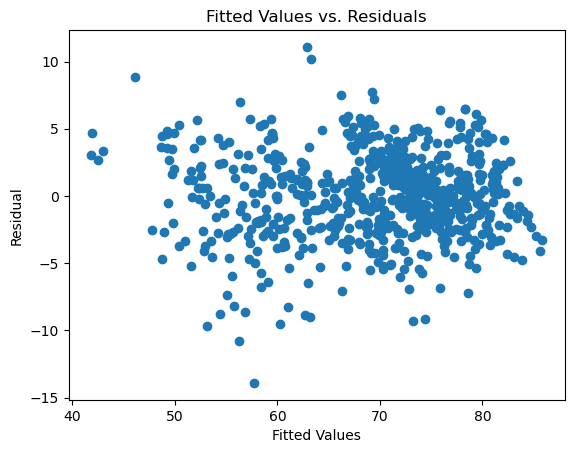

In [26]:
p = baseline.fittedvalues
res = baseline.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")
plt.show()

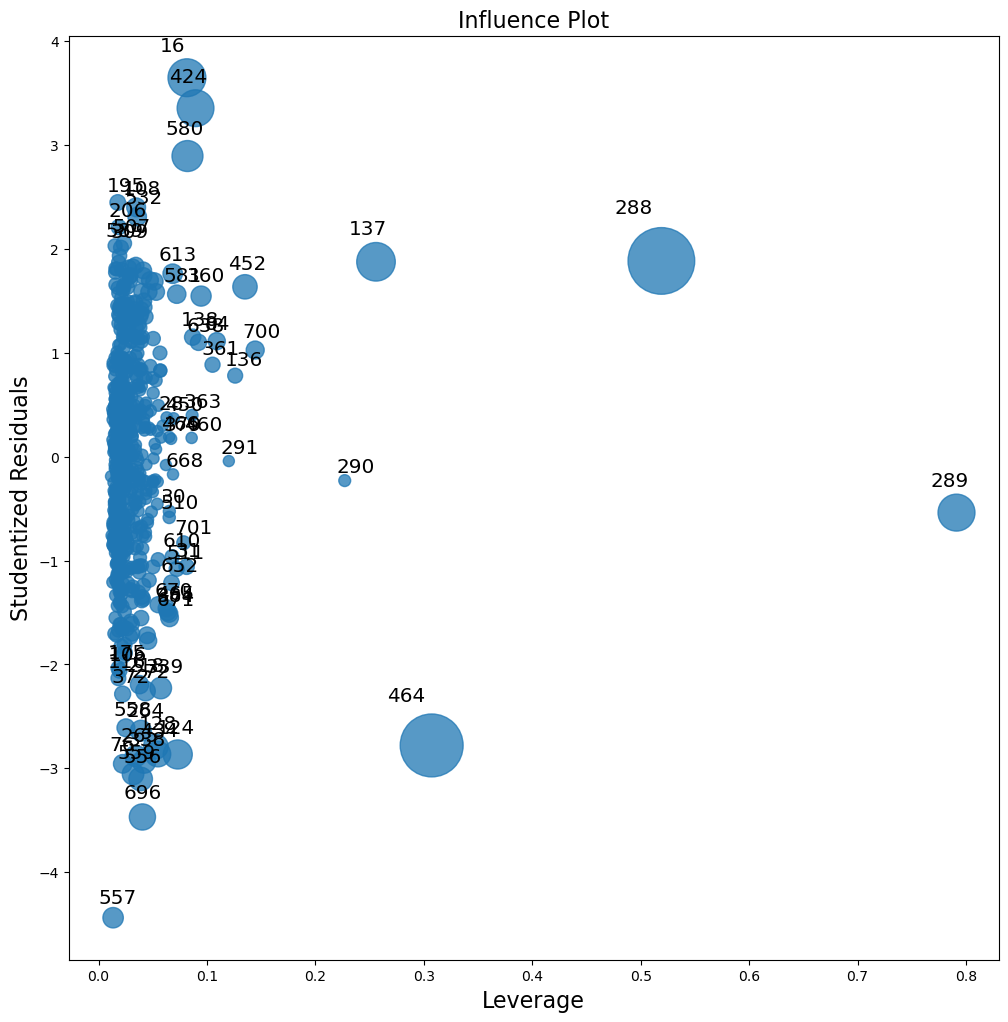

In [27]:
infl = baseline.get_influence()
fig, ax = plt.subplots(figsize=(12,12))
fig=sm.graphics.influence_plot(baseline, ax=ax, criterion="cooks") 

In [28]:
n = grouped_new.shape[0]
p = len(baseline.params)
 
reg_studs=infl.resid_studentized_external

seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud
orig_resids = baseline.resid

for idx in grouped_new.index[atyp_stud]:
    print(f"Observation: {idx}, External Studentized Residual: {reg_studs[idx]}, Original Residual: {orig_resids[idx]}")

Observation: 16, External Studentized Residual: 3.648054619503604, Original Residual: 11.087527120965639
Observation: 76, External Studentized Residual: -2.956146999700451, Original Residual: -9.3002402989624
Observation: 106, External Studentized Residual: -2.060637701187619, Original Residual: -6.5140044758722055
Observation: 108, External Studentized Residual: 2.400278661173453, Original Residual: 7.519916752799645
Observation: 116, External Studentized Residual: -2.132453749027321, Original Residual: -6.743185337523116
Observation: 124, External Studentized Residual: -2.8659217603931144, Original Residual: -8.782849257464711
Observation: 128, External Studentized Residual: -2.79047012822935, Original Residual: -8.646939038185934
Observation: 175, External Studentized Residual: -2.0353196164277416, Original Residual: -6.438306316291424
Observation: 195, External Studentized Residual: 2.447310896823567, Original Residual: 7.733063338218585
Observation: 206, External Studentized Resid

In [29]:
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n
print(grouped_new.index[atyp_cook],reg_cook[atyp_cook])

Int64Index([ 16,  76,  84, 108, 124, 128, 137, 138, 218, 225, 226, 264, 265,
            272, 288, 289, 338, 339, 342, 360, 384, 424, 434, 440, 444, 452,
            464, 465, 532, 556, 557, 558, 559, 561, 580, 581, 613, 670, 671,
            680, 696, 700],
           dtype='int64') 16     0.052692
76     0.008943
84     0.006875
108    0.009319
124    0.029076
128    0.019523
137    0.054810
138    0.005717
218    0.008530
225    0.007006
226    0.005938
264    0.012712
265    0.013255
272    0.010395
288    0.173599
289    0.049940
338    0.016934
339    0.013632
342    0.006250
360    0.011320
384    0.007191
424    0.049468
434    0.021324
440    0.006497
444    0.006808
452    0.018926
464    0.154137
465    0.006888
532    0.008898
556    0.017417
557    0.011798
558    0.007923
559    0.013729
561    0.006249
580    0.033624
581    0.008619
613    0.010313
670    0.006453
671    0.007635
680    0.006388
696    0.022630
700    0.008090
Name: cooks_d, dtype: float64


In [30]:
resids = list(grouped_new.index[atyp_stud])
cooks = list(grouped_new.index[atyp_cook])

outliers = list(set(resids) & set(cooks))
outliers

[128,
 264,
 265,
 272,
 16,
 532,
 424,
 556,
 557,
 558,
 559,
 434,
 696,
 580,
 76,
 464,
 338,
 339,
 218,
 108,
 124]

In [31]:
no_outliers = grouped_new.drop(outliers)
no_outliers.shape

(683, 19)

In [32]:
baseline_dropped = smf.ols('Life_expectancy ~ C(region) + C(Status) + C(Year_Cohort) + Adult_Mortality + infant_deaths + Alcohol + Hepatitis_B + Measles + BMI + Polio + Total_expenditure + Diphtheria + HIV_AIDS + GDP + Population + Schooling', data=no_outliers).fit()

bp_test = het_breuschpagan(baseline_dropped.resid, baseline_dropped.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 49.62911546828843, 'LM-Test p-value': 0.00041073137051965896}


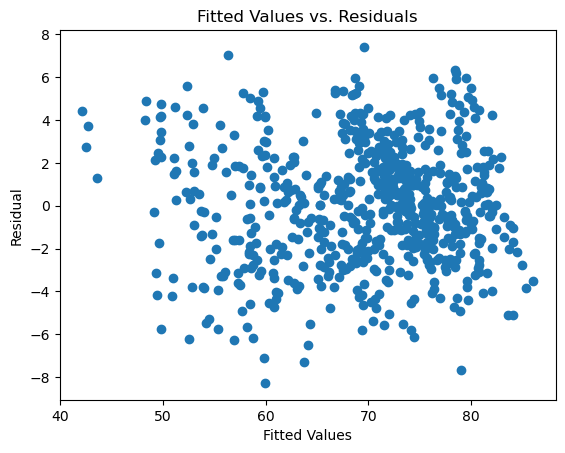

In [33]:
p = baseline_dropped.fittedvalues
res = baseline_dropped.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")
plt.show()

In [34]:
no_outliers['log_life_expectancy'] = np.log(no_outliers['Life_expectancy'])

model_log = smf.ols('log_life_expectancy ~ C(region) + C(Year_Cohort) + Adult_Mortality + infant_deaths + Alcohol + Hepatitis_B + Measles + BMI + Polio + Total_expenditure + Diphtheria + HIV_AIDS + GDP + Population + Schooling',
                    data = no_outliers).fit()

# Breusch-Pagan for Heteroskedasticity
bp_test = het_breuschpagan(model_log.resid, model_log.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 111.46851023627165, 'LM-Test p-value': 1.0593569843086439e-14}


SignificanceResult(statistic=28.956479910626047, pvalue=5.154425652497218e-07)

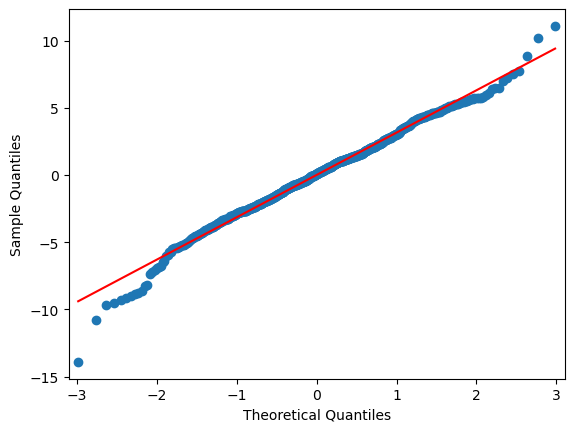

In [35]:
sm.qqplot(baseline.resid, line = 's')
jarque_bera(baseline.resid)

SignificanceResult(statistic=2.2838370048645653, pvalue=0.31920603644004225)

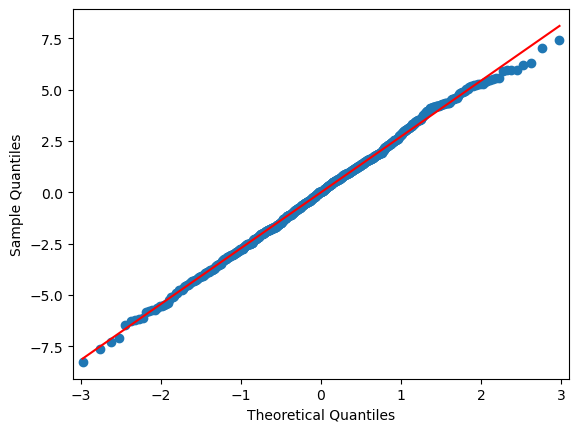

In [36]:
sm.qqplot(baseline_dropped.resid, line = 's')
jarque_bera(baseline_dropped.resid)

In [37]:
#extact HCE variance-coviance matrix
V_HC_1 =baseline.cov_HC0
print(np.round(baseline.get_robustcov_results(cov_type = "HC0").summary2().tables[0]))
print(np.round(baseline.get_robustcov_results(cov_type = "HC0").summary2().tables[1], 5))

                     0                 1                    2          3
0               Model:               OLS      Adj. R-squared:      0.883
1  Dependent Variable:   Life_expectancy                 AIC:  3657.0913
2                Date:  2023-10-11 21:05                 BIC:  3757.3404
3    No. Observations:               704      Log-Likelihood:    -1806.5
4            Df Model:                21         F-statistic:      261.8
5        Df Residuals:               682  Prob (F-statistic):  6.51e-304
6           R-squared:             0.886               Scale:     10.238
                                Coef.  Std.Err.         t    P>|t|    [0.025  \
Intercept                    56.02359   1.42835  39.22250  0.00000  53.21909   
C(region)[T.Americas]         4.57748   0.51782   8.83992  0.00000   3.56077   
C(region)[T.Asia]             3.06596   0.40922   7.49219  0.00000   2.26248   
C(region)[T.Europe]           3.53442   0.63829   5.53731  0.00000   2.28117   
C(region)[T.Ocea

/Users/shenyaxuan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 20
  warnings.warn('covariance of constraints does not have full '
/Users/shenyaxuan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 20
  warnings.warn('covariance of constraints does not have full '


In [38]:
#extact HCE variance-coviance matrix
V_HC_1 =baseline_dropped.cov_HC0
print(np.round(baseline_dropped.get_robustcov_results(cov_type = "HC0").summary2().tables[0]))
print(np.round(baseline_dropped.get_robustcov_results(cov_type = "HC0").summary2().tables[1], 5))

                     0                 1                    2          3
0               Model:               OLS      Adj. R-squared:      0.906
1  Dependent Variable:   Life_expectancy                 AIC:  3351.8218
2                Date:  2023-10-11 21:05                 BIC:  3451.4047
3    No. Observations:               683      Log-Likelihood:    -1653.9
4            Df Model:                21         F-statistic:      295.9
5        Df Residuals:               661  Prob (F-statistic):  8.63e-314
6           R-squared:             0.909               Scale:     7.6748
                                Coef.  Std.Err.         t    P>|t|    [0.025  \
Intercept                    58.12874   1.21828  47.71392  0.00000  55.73658   
C(region)[T.Americas]         4.01957   0.43791   9.17906  0.00000   3.15971   
C(region)[T.Asia]             2.38422   0.35884   6.64423  0.00000   1.67962   
C(region)[T.Europe]           2.96987   0.53195   5.58300  0.00000   1.92535   
C(region)[T.Ocea

/Users/shenyaxuan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 20
  warnings.warn('covariance of constraints does not have full '
/Users/shenyaxuan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 20
  warnings.warn('covariance of constraints does not have full '


In [39]:
N = len(grouped_new)
P = len(baseline.get_robustcov_results(cov_type="HC0").params)
res_full = baseline.get_robustcov_results(cov_type = "HC0").resid
sse_full = sum(res_full**2)
s2 = sse_full / (N - P)

def results1(params):
    model = smf.ols(params, data = grouped_new).fit()
    adj_r2 = model.get_robustcov_results(cov_type="HC0").rsquared_adj
    k1 = len(model.get_robustcov_results(cov_type="HC0").params)
    sse1 = sum(model.get_robustcov_results(cov_type="HC0").resid**2)
    cp = sse1/s2 - (704-2*k1)
    predictors = params.split('~')[-1]
    return predictors, adj_r2, cp

In [40]:
N2 = len(no_outliers)
P2 = len(baseline_dropped.get_robustcov_results(cov_type="HC0").params)
res = baseline_dropped.get_robustcov_results(cov_type = "HC0").resid
sse = sum(res_full**2)
s_2 = sse / (N2 - P2)

def results2(params):
    model = smf.ols(params, data = grouped_new).fit()
    adj_r2 = model.get_robustcov_results(cov_type="HC0").rsquared_adj
    k1 = len(model.get_robustcov_results(cov_type="HC0").params)
    sse1 = sum(model.get_robustcov_results(cov_type="HC0").resid**2)
    cp = sse1/s_2 - (683-2*k1)
    predictors = params.split('~')[-1]
    return predictors, adj_r2, cp

In [41]:
def generate_model_combinations(response_var, predictors):
    models = []

    # Add the individual predictors to the models list
    for predictor in predictors:
        models.append(f"{response_var} ~ {predictor}")

    # Add combinations of predictors to the models list
    for r in range(2, len(predictors) + 1):
        for subset in combinations(predictors, r):
            model = f"{response_var} ~ {' + '.join(subset)}"
            models.append(model)

    return models

response_var = 'Life_expectancy'
predictors = ['C(region)', 'C(Status)', 'Adult_Mortality', 'Alcohol', 'Hepatitis_B', 'BMI', 'Polio', 'Diphtheria', 'HIV_AIDS', 'GDP', 'Schooling']

models = generate_model_combinations(response_var, predictors)
print(len(models))
print(models[:20])

2047
['Life_expectancy ~ C(region)', 'Life_expectancy ~ C(Status)', 'Life_expectancy ~ Adult_Mortality', 'Life_expectancy ~ Alcohol', 'Life_expectancy ~ Hepatitis_B', 'Life_expectancy ~ BMI', 'Life_expectancy ~ Polio', 'Life_expectancy ~ Diphtheria', 'Life_expectancy ~ HIV_AIDS', 'Life_expectancy ~ GDP', 'Life_expectancy ~ Schooling', 'Life_expectancy ~ C(region) + C(Status)', 'Life_expectancy ~ C(region) + Adult_Mortality', 'Life_expectancy ~ C(region) + Alcohol', 'Life_expectancy ~ C(region) + Hepatitis_B', 'Life_expectancy ~ C(region) + BMI', 'Life_expectancy ~ C(region) + Polio', 'Life_expectancy ~ C(region) + Diphtheria', 'Life_expectancy ~ C(region) + HIV_AIDS', 'Life_expectancy ~ C(region) + GDP']


In [42]:
w_outliers = []
wo_outliers = []
for model in models:
    w_outliers.append(results1(model))
    wo_outliers.append(results2(model))
sorted1_r2 = sorted(w_outliers, key=lambda x: x[1], reverse=True)
sorted1_cp = sorted(w_outliers, key=lambda x: x[2])
sorted2_r2 = sorted(wo_outliers, key=lambda x: x[1], reverse=True)
sorted2_cp = sorted(wo_outliers, key=lambda x: x[2])

In [43]:
#sorted1_r2[:5]
sorted2_r2[:5]

[(' C(region) + C(Status) + Adult_Mortality + Alcohol + Hepatitis_B + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling',
  0.8824311167733534,
  16.03802590254668),
 (' C(region) + C(Status) + Adult_Mortality + Hepatitis_B + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling',
  0.8811745920954559,
  22.169816526522368),
 (' C(region) + C(Status) + Adult_Mortality + Alcohol + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling',
  0.881121231866361,
  22.47390920487544),
 (' C(region) + Adult_Mortality + Alcohol + Hepatitis_B + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling',
  0.8807511742083901,
  24.582817398597285),
 (' C(region) + C(Status) + Adult_Mortality + Alcohol + Hepatitis_B + BMI + Polio + HIV_AIDS + GDP + Schooling',
  0.8805126336272447,
  25.94222768312318)]

In [44]:
#sorted1_cp[:5]
sorted2_cp[:10]

[(' C(region) + C(Status) + Adult_Mortality + Alcohol + Hepatitis_B + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling',
  0.8824311167733534,
  16.03802590254668),
 (' C(region) + C(Status) + Adult_Mortality + Hepatitis_B + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling',
  0.8811745920954559,
  22.169816526522368),
 (' C(region) + C(Status) + Adult_Mortality + Alcohol + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling',
  0.881121231866361,
  22.47390920487544),
 (' C(region) + Adult_Mortality + Alcohol + Hepatitis_B + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling',
  0.8807511742083901,
  24.582817398597285),
 (' C(region) + C(Status) + Adult_Mortality + Alcohol + Hepatitis_B + BMI + Polio + HIV_AIDS + GDP + Schooling',
  0.8805126336272447,
  25.94222768312318),
 (' C(region) + Adult_Mortality + Hepatitis_B + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling',
  0.8801819409321615,
  26.816404372987336),
 (' C(region) + C(Status) + Adult_Mortality + BMI

In [45]:
df = pd.DataFrame(columns=['AIC', 'BIC'])

model1 = smf.ols('Life_expectancy ~ C(region) + C(Status) + Adult_Mortality + Alcohol + Hepatitis_B + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling', data = grouped_new).fit()
df.loc[1] = {'AIC': model1.get_robustcov_results(cov_type="HC0").aic , 'BIC': model1.get_robustcov_results(cov_type="HC0").bic}

model2 = smf.ols('Life_expectancy ~ C(region) + C(Status) + Adult_Mortality + Hepatitis_B + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling', data = grouped_new).fit()
df.loc[2] = {'AIC': model2.get_robustcov_results(cov_type="HC0").aic , 'BIC': model2.get_robustcov_results(cov_type="HC0").bic}

model3 = smf.ols('Life_expectancy ~ C(region) + C(Status) + Adult_Mortality + Alcohol + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling', data = grouped_new).fit()
df.loc[3] = {'AIC': model3.get_robustcov_results(cov_type="HC0").aic , 'BIC': model3.get_robustcov_results(cov_type="HC0").bic}

df

,AIC,BIC
1,3651.600601,3719.952277
2,3658.105752,3721.900649
3,3658.421822,3722.216719


In [46]:
print(f"Final model:{results2('Life_expectancy ~ C(region) + C(Status) + Adult_Mortality + Alcohol + Hepatitis_B + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling')}, {model1.get_robustcov_results(cov_type='HC0').aic},{model1.get_robustcov_results(cov_type='HC0').bic}")


Final model:(' C(region) + C(Status) + Adult_Mortality + Alcohol + Hepatitis_B + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling', 0.8824311167733534, 16.03802590254668), 3651.600601458152,3719.9522768005227


In [47]:
df2 = pd.DataFrame(columns=['AIC', 'BIC'])

model4 = smf.ols('Life_expectancy ~ C(region) + C(Status) + Adult_Mortality + Alcohol + Hepatitis_B + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling', data = no_outliers).fit()
df2.loc[1] = {'AIC': model4.get_robustcov_results(cov_type="HC0").aic , 'BIC': model4.get_robustcov_results(cov_type="HC0").bic}

model5 = smf.ols('Life_expectancy ~ C(region) + C(Status) + Adult_Mortality + Hepatitis_B + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling', data = no_outliers).fit()
df2.loc[2] = {'AIC': model5.get_robustcov_results(cov_type="HC0").aic , 'BIC': model5.get_robustcov_results(cov_type="HC0").bic}

model6 = smf.ols('Life_expectancy ~ C(region) + C(Status) + Adult_Mortality + Alcohol + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling', data = no_outliers).fit()
df2.loc[3] = {'AIC': model6.get_robustcov_results(cov_type="HC0").aic , 'BIC': model6.get_robustcov_results(cov_type="HC0").bic}

df2

,AIC,BIC
1,3346.745259,3414.642682
2,3353.686439,3417.057367
3,3349.894046,3413.264974


In [48]:
print(f"Final model: {results2('Life_expectancy ~ C(region) + C(Status) + Adult_Mortality + Alcohol + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling')}, {model6.get_robustcov_results(cov_type='HC0').aic}, {model6.get_robustcov_results(cov_type='HC0').bic}")

Final model: (' C(region) + C(Status) + Adult_Mortality + Alcohol + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling', 0.881121231866361, 22.47390920487544), 3349.89404628218, 3413.2649743161714


In [49]:
model1.get_robustcov_results(cov_type="HC0").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     355.0
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          1.05e-303
Time:                        21:05:57   Log-Likelihood:                -1810.8
No. Observations:                 704   AIC:                             3652.
Df Residuals:                     689   BIC:                             3720.
Df Model:                          14                                         
Covariance Type:                  HC0                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  55.1553      1.373     40.166      0.000      52.459      57.851
C(region)[T.Americas]       4.5012      0.514      8.751      0.000       3.491       5.511
C(region)[T.Asia]           2.8636      0.398      7.190      0.000       2.082       3.646
C(region)[T.Europe]         3.4485      0.645      5.344      0.000       2.182       4.715
C(region)[T.Oceania]        1.8565      0.701      2.648      0.008       0.480       3.233
C(Status)[T.Developing]    -1.6997      0.496     -3.430      0.001      -2.673      -0.727
Adult_Mortality            -0.0248      0.003     -8.524      0.000      -0.031      -0.019
Alcohol                    -0.1486      0.053     -2.794      0.005      -0.253      -0.044
Hepatitis_B                -0.0227      0.008     -2.943      0.003      -0.038      -0.008
BMI                         0.0435      0.010      4.195      0.000       0.023       0.064
Polio                       0.0561      0.014      4.016      0.000       0.029       0.084
Diphtheria                  0.0446      0.014      3.224      0.001       0.017       0.072
HIV_AIDS                   -0.3310      0.060     -5.520      0.000      -0.449      -0.213
GDP                      8.185e-05   1.24e-05      6.614      0.000    5.76e-05       0.000
Schooling                   0.8016      0.097      8.252      0.000       0.611       0.992
==============================================================================
Omnibus:                       22.376   Durbin-Watson:                   1.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.706
Skew:                          -0.274   Prob(JB):                     4.79e-08
Kurtosis:                       3.921   Cond. No.                     1.26e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
model6.get_robustcov_results(cov_type="HC0").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     439.0
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          4.58e-317
Time:                        21:05:57   Log-Likelihood:                -1660.9
No. Observations:                 683   AIC:                             3350.
Df Residuals:                     669   BIC:                             3413.
Df Model:                          13                                         
Covariance Type:                  HC0                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  57.3635      1.178     48.681      0.000      55.050      59.677
C(region)[T.Americas]       3.9619      0.431      9.200      0.000       3.116       4.807
C(region)[T.Asia]           2.2367      0.344      6.494      0.000       1.560       2.913
C(region)[T.Europe]         3.0076      0.527      5.709      0.000       1.973       4.042
C(region)[T.Oceania]        1.8832      0.592      3.181      0.002       0.721       3.046
C(Status)[T.Developing]    -1.4374      0.475     -3.027      0.003      -2.370      -0.505
Adult_Mortality            -0.0317      0.002    -14.803      0.000      -0.036      -0.027
Alcohol                    -0.1325      0.045     -2.952      0.003      -0.221      -0.044
BMI                         0.0323      0.009      3.513      0.000       0.014       0.050
Polio                       0.0401      0.012      3.316      0.001       0.016       0.064
Diphtheria                  0.0327      0.012      2.639      0.008       0.008       0.057
HIV_AIDS                   -0.2391      0.047     -5.056      0.000      -0.332      -0.146
GDP                      7.448e-05   1.14e-05      6.535      0.000    5.21e-05    9.69e-05
Schooling                   0.8023      0.067     11.977      0.000       0.671       0.934
==============================================================================
Omnibus:                        1.965   Durbin-Watson:                   1.257
Prob(Omnibus):                  0.374   Jarque-Bera (JB):                1.816
Skew:                          -0.040   Prob(JB):                        0.403
Kurtosis:                       2.760   Cond. No.                     1.32e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
y, X = dmatrices('Life_expectancy ~ C(region) + C(Status) + Adult_Mortality + Alcohol + BMI + Polio + Diphtheria + HIV_AIDS + GDP + Schooling',
                 data=no_outliers, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor                 features
0    84.703443                Intercept
1     2.584843    C(region)[T.Americas]
2     2.135760        C(region)[T.Asia]
3     4.518901      C(region)[T.Europe]
4     1.536590     C(region)[T.Oceania]
5     2.692672  C(Status)[T.Developing]
6     3.521538          Adult_Mortality
7     2.987322                  Alcohol
8     2.272679                      BMI
9     3.749289                    Polio
10    3.819362               Diphtheria
11    2.186980                 HIV_AIDS
12    1.730170                      GDP
13    3.298323                Schooling


In [52]:
final_model = model6
final_model.get_robustcov_results(cov_type="HC0").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     439.0
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          4.58e-317
Time:                        21:05:57   Log-Likelihood:                -1660.9
No. Observations:                 683   AIC:                             3350.
Df Residuals:                     669   BIC:                             3413.
Df Model:                          13                                         
Covariance Type:                  HC0                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  57.3635      1.178     48.681      0.000      55.050      59.677
C(region)[T.Americas]       3.9619      0.431      9.200      0.000       3.116       4.807
C(region)[T.Asia]           2.2367      0.344      6.494      0.000       1.560       2.913
C(region)[T.Europe]         3.0076      0.527      5.709      0.000       1.973       4.042
C(region)[T.Oceania]        1.8832      0.592      3.181      0.002       0.721       3.046
C(Status)[T.Developing]    -1.4374      0.475     -3.027      0.003      -2.370      -0.505
Adult_Mortality            -0.0317      0.002    -14.803      0.000      -0.036      -0.027
Alcohol                    -0.1325      0.045     -2.952      0.003      -0.221      -0.044
BMI                         0.0323      0.009      3.513      0.000       0.014       0.050
Polio                       0.0401      0.012      3.316      0.001       0.016       0.064
Diphtheria                  0.0327      0.012      2.639      0.008       0.008       0.057
HIV_AIDS                   -0.2391      0.047     -5.056      0.000      -0.332      -0.146
GDP                      7.448e-05   1.14e-05      6.535      0.000    5.21e-05    9.69e-05
Schooling                   0.8023      0.067     11.977      0.000       0.671       0.934
==============================================================================
Omnibus:                        1.965   Durbin-Watson:                   1.257
Prob(Omnibus):                  0.374   Jarque-Bera (JB):                1.816
Skew:                          -0.040   Prob(JB):                        0.403
Kurtosis:                       2.760   Cond. No.                     1.32e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
bp_test = het_breuschpagan(final_model.resid, final_model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 47.182099012096366, 'LM-Test p-value': 9.001504948557459e-06}


SignificanceResult(statistic=1.816027147368408, pvalue=0.40332460342916476)

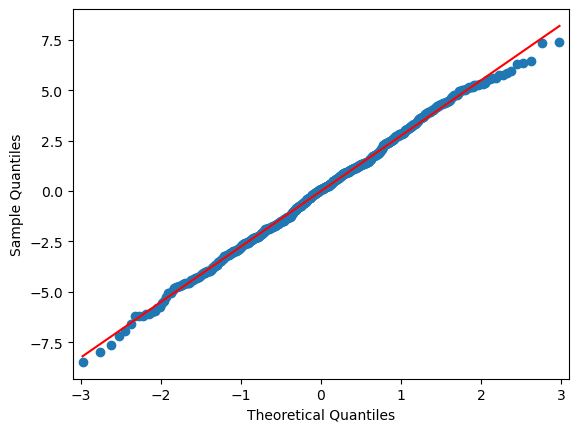

In [54]:
sm.qqplot(final_model.resid, line = 's')
jarque_bera(final_model.resid)